# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

In [2]:
# Check shape of train and test datasets

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [3]:
train.shape, test.shape

((51916, 17), (17306, 17))

In [4]:
# Copy train and test so don't have to download multiple times
# Plus, rename to X and y

X_train = train.copy()
X_test = test.copy()

In [5]:
# Define target for both train1 and test1

y_train = X_train['Fail']
y_test = X_test['Fail']

In [6]:
# Check shapes

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51916, 17), (17306, 17), (51916,), (17306,))

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

In [7]:
import category_encoders as ce

# Aim for 'first, fast' baseline
# Start preprocessing by dropping nulls from all df's
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train.dropna()
y_test = y_test.dropna()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41665, 17), (13822, 17), (51916,), (17306,))

In [9]:
# Need to reshape before encoding data
# Need X_train and y_train to have same shape[0]
# Also need X_test and y_test to have same?

import numpy as np

y_train_random_sample = np.random.choice(y_train.index.values, 41665)
sampled_y_train = y_train.loc[y_train_random_sample]
y_test_random_sample = np.random.choice(y_test.index.values, 13822)
sampled_y_test = y_test.loc[y_test_random_sample]

X_train.shape, X_test.shape, sampled_y_train.shape, sampled_y_test.shape

((41665, 17), (13822, 17), (41665,), (13822,))

In [ ]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._

In [10]:
# First work is for baseline modeling

import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [ ]:
# With reshaping done, fit model, then compute cross_val_score

gb = GradientBoostingClassifier()
gb.fit(X_train, sampled_y_train)
cross_val_score(gb, X_test, sampled_y_test, scoring='roc_auc', cv=5, n_jobs=-1)

In [ ]:
# Use GBC model to predict probabilities for test set

y_pred_proba = gb.predict_proba(X_test)[:,1]
print('Validation ROC AUC:', roc_auc_score(sampled_y_test, y_pred_proba))
# Result with -all- nulls dropped: Validation ROC AUC: 0.4865806166685149

In [12]:
## Need more accuracy, so create X1 and y1, and use RH 'wrangle' function for feature engineering

from xgboost import XGBClassifier

X1_train = train.copy()
X1_test = test.copy()
y1_train = X1_train['Fail']
y1_test = X1_test['Fail']

X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((51916, 17), (17306, 17), (51916,), (17306,))

In [13]:
# For this modeling, don't drop nulls at beginning, but do
# drop 'Facility Type', 'Address', and 'Zip' because of high cardinality

X1_train = X1_train.drop(columns=['Facility Type', 'Address', 'Zip'])
X1_test = X1_test.drop(columns=['Facility Type', 'Address', 'Zip'])

In [14]:
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((51916, 14), (17306, 14), (51916,), (17306,))

In [16]:
encoder = ce.OrdinalEncoder(handle_unknown='ignore')  # , cols=[col for col in X_train])
X1_transformed = encoder.fit_transform(X1_train)
X1_transformed = X1_transformed.select_dtypes(include='number')
X1_test = encoder.transform(X1_test)
X1_test = X1_test.select_dtypes(include='number')

In [17]:
model = XGBClassifier()
cross_val_score(model, X1_transformed, y1_train, scoring='roc_auc', cv=5, n_jobs=-1)

array([1., 1., 1., 1., 1.])

In [18]:
model.fit(X1_transformed, y1_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [19]:
y1_pred_proba = model.predict_proba(X1_test)[:,1]

In [21]:
print('Validation ROC AUC:', roc_auc_score(y1_test, y1_pred_proba))

Validation ROC AUC: 1.0


In [22]:
X1_train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Risk', 'City',
       'State', 'Inspection Date', 'Inspection Type', 'Violations', 'Latitude',
       'Longitude', 'Location', 'Fail'],
      dtype='object')

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d9ac4eb5c0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1d9acd42908>})

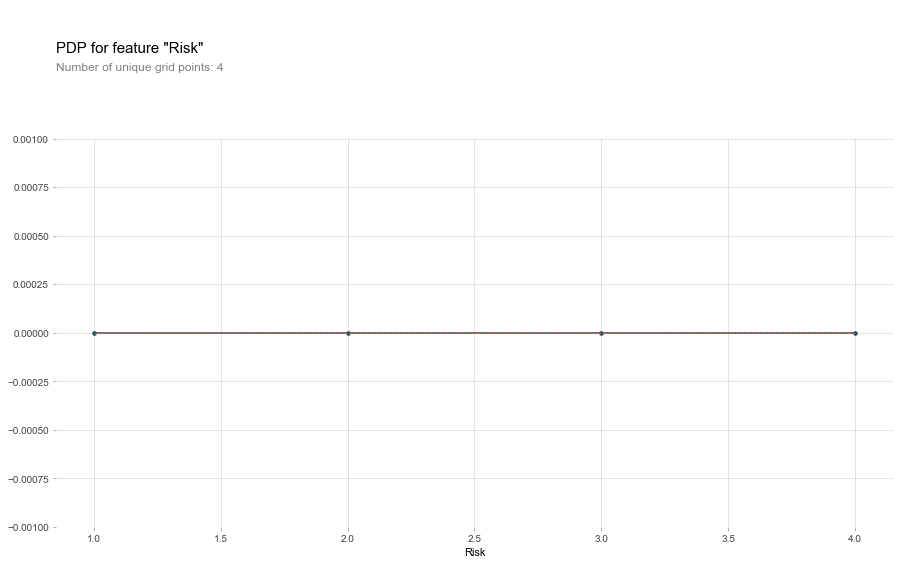

In [26]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Risk'
pdp_isolated = pdp_isolate(model=model, dataset=X1_test, model_features=X1_test.columns, feature=feature)
pdp_plot(pdp_isolated, feature)